Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

TODO: function to read existing vois, drop one class, then load the class back in. Requires that drm.load_imgs write to a DataFrame rather than an array

In [3]:
import config
import dr_methods as drm
import helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import voi_methods as vm
%matplotlib inline

In [12]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(vm)
importlib.reload(drm)
C = config.Config()

# Read Run Stats

In [74]:
import re
import operator

df = pd.read_csv(C.run_stats_path)

df = df.dropna(subset=['misclassified_test'])
df = df.loc[:,['misclassified_test','misclassified_train']]
#df = df.dropna()
#b = a.iloc[0]['y_pred_raw']
#b = hf.str_to_lists(b)

mis_test = df['misclassified_train'].values
#mis_test = df['misclassified_test'].values

mis_test = ''.join(mis_test)
mis_test = mis_test.replace(' ','')
mis_test = mis_test.replace("'","")
mis_test = re.sub(r'\]\[', ',', mis_test)
mis_test = mis_test.replace("[","")
mis_test = mis_test.replace("]","")

mis_test = mis_test.split(',')

unique, counts = np.unique(mis_test, return_counts=True)

x = dict(zip(unique, counts))

sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
sorted_x

# Reload images and VOIs

In [ ]:
drm.load_vois_all(C)

In [234]:
for cls in C.classes_to_include:
    if not os.path.exists(C.full_img_dir + "\\" + cls):
        os.makedirs(C.full_img_dir + "\\" + cls)
    if not os.path.exists(C.orig_dir + cls):
        os.makedirs(C.orig_dir + cls)
    if not os.path.exists(C.aug_dir + cls):
        os.makedirs(C.aug_dir + cls)
    if not os.path.exists(C.crops_dir + cls):
        os.makedirs(C.crops_dir + cls)

In [ ]:
voi_dfs = init_voi_dfs()

In [ ]:
#dims_df = pd.DataFrame(columns = ["AccNum", "x", "y", "z"])
dims_df = pd.read_csv(C.dims_df_path)
voi_df_art = pd.DataFrame(columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls",
                                     "flipz", "real_dx", "real_dy", "real_dz", "id", "lesion_num"])
voi_df_ven = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_df_eq = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]

In [183]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]
dims_df = pd.read_csv(C.dims_df_path)
intensity_df = pd.read_csv(C.int_df_path)
#intensity_df = drm.get_intensities(C, cls="hcc", acc_num='E106046622')

In [ ]:
intensity_df = drm.get_intensities(C, cls="hemangioma", acc_num='13138944')

In [ ]:
patient_info_df = pd.DataFrame(columns = ["MRN", "Sex", "AccNum", "AgeAtImaging", "cls"])
for i in [C.sheetnames.index(x) for x in ['HCC']]:
    #drm.check_folders(img_dirs[i], xls_name, sheetnames[i], C)
    #dims_df = drm.load_imgs(img_dirs[i], cls_names[i], xls_name, sheetnames[i], dims_df, C)
    #voi_dfs = drm.load_vois_batch(cls_names[i], voi_dfs, dims_df, C)#, acc_nums=['E104764948','E106046622'])
    #intensity_df = drm.get_intensities(C, cls=cls_names[i], acc_num='E106046622')
    patient_info_df = drm.load_patient_info("Z:\\"+C.img_dirs[i], C.cls_names[i], C.sheetnames[i], patient_info_df, C,
                                           acc_nums=['12916368'])
patient_info_df.to_csv('Z:\\patient_info_missing.csv', index=False)

In [187]:
#voi_df_art, voi_df_ven, voi_df_eq = voi_dfs
voi_df_art.to_csv(C.art_voi_path, index=False)
voi_df_ven.to_csv(C.ven_voi_path, index=False)
voi_df_eq.to_csv(C.eq_voi_path, index=False)

In [ ]:
dims_df.to_csv(C.dims_df_path, index=False)

In [ ]:
#drm.delete_imgs(['12916368', 'E102556695'], 'hcc', C)
#drm.delete_imgs(0, cls, C, xls_name, sheetname)
drm.reload_imgs(["E100165687"], "hemangioma", C)

In [ ]:
vm.xref_dirs_with_excel(C)

In [73]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_art[voi_df_art["Filename"] == "12678910.npy"]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num
71,12678910.npy,79,87,127,138,44,50,hemangioma,False,9.722222,13.368056,18.0,12678910_0,0
72,12678910.npy,99,114,113,130,53,63,hemangioma,False,18.229167,20.659722,30.0,12678910_1,1
73,12678910.npy,127,140,106,124,71,76,hemangioma,False,15.798611,21.875000,15.0,12678910_2,2


# Generate cropped imgs

In [62]:
small_voi_df = pd.read_csv(C.small_voi_path)
small_voi_df[small_voi_df["acc_num"] == "13094833"]

,id,acc_num,cls,coords
145,13094833_0,13094833,cholangio,"[27, 57, 24, 51, 11, 24]"


In [29]:
for acc_num in ['E103985934']:
    vm.reload_accnum(acc_num, "cyst", C, augment=True, overwrite=True)


Loading VOIs for ['E103985934']
.Overall time: 1.4305405616760254
.
2.0651533603668213
0.06147456169128418


In [102]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
intensity_df = pd.read_csv(C.int_df_path)

In [12]:
#small_voi_df = pd.DataFrame(columns=["id", "acc_num", "cls", "coords"])
#small_voi_df = vm.extract_vois(small_voi_df, C, voi_df_art, voi_df_ven, voi_df_eq, debug=True)#, classes=["fnh"], acc_nums=["E100165687"])
small_voi_df.to_csv(C.small_voi_path, index=False)

In [ ]:
# scaled imgs
vm.save_unaugment_set()

for cls in C.classes_to_include:
    vm.save_vois_as_imgs(cls, C)

In [13]:
# augmented imgs
vm.parallel_augment(num_cores=3, overwrite=100)

hcc 171.11602544784546
cholangio 239.56331133842468
colorectal 373.1854989528656
cyst 596.2553129196167
hemangioma 722.2835092544556
fnh 916.3784506320953


# Plotting

In [60]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_art[voi_df_art["Filename"] == "E105427046.npy"]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num
289,E105427046.npy,141,202,177,243,11,25,cholangio,False,47.65625,51.5625,49.0,E105427046_0,0


In [ ]:
# can be used to determine if an image is flipped
cls = "cholangio"
acc_num = '11534565'#acc_nums[0]
img_fn = acc_num + ".npy"
img = np.load(C.full_img_dir+"\\"+cls + "\\"+img_fn)
hf.plot_slice_flips(img, voi_df_art[(voi_df_art["Filename"] == img_fn) & (voi_df_art["cls"] == cls)].iloc[0], flipz="both", pad=10)
print(np.amin(img), np.amax(img), np.mean(img))
#hf.plot_section_auto(img)

-1.0 0.803167420814 -0.103097555201


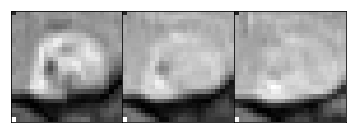

In [81]:
# Cropped, rescaled or augmented imgs
img = drm.plot_check("cholangio", 2, C, "13094833"+"_0")
print(np.amin(img), np.amax(img), np.mean(img))

# Run CNN

In [ ]:
import cnn_builder as cbuild
importlib.reload(cbuild)
cbuild.overnight_run(C)

# Situational

In [76]:
df = pd.read_excel(xls_name, sheetname)
df = drm.preprocess_df(df, C)
acc_nums = list(set(df['Patient E Number'].dropna().astype(str).tolist()))

In [ ]:
for img_fn in sorted(set(voi_df[voi_df["cls"] == "cyst"]['Filename'])):
    img = np.load("full_imgs\\"+img_fn)
    if np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,:img.shape[2]//3]) > \
            np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,(img.shape[2]+1)*2//3:]):
        print(img_fn)

for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" in img_fn:
            os.remove(C.aug_dir + cls + "\\" + img_fn)

img = img * 2 - 1

for cls in C.classes_to_include:
    fns = os.listdir(C.crops_dir + cls)
    for fn in fns:
        img = np.load(C.crops_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.crops_dir + cls + "\\" + fn, img)

for cls in C.classes_to_include:
    fns = os.listdir(C.orig_dir + cls)
    for fn in fns:
        img = np.load(C.orig_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.orig_dir + cls + "\\" + fn, img)

for cls in C.classes_to_include:
    fns = os.listdir(C.aug_dir + cls)
    for fn in fns:
        img = np.load(C.aug_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.aug_dir + cls + "\\" + fn, img)

for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" not in img_fn:
            img = np.load(C.aug_dir + cls + "\\" + img_fn)
            aug_img = tr.generate_reflected_img(img)
            np.save(C.aug_dir + cls + "\\" + img_fn[:-4] + "-refl", aug_img)